In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image, ImageDraw
import random
import torch.optim as optim
device = "cuda" if torch.cuda.is_available() else "cpu"

c:\Users\JSH\Desktop\MyGithub\paper_implementation\.paper_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from SSD.model import SSD
num_classes = 10
model = SSD()
model = model.to(device)

c:\Users\JSH\Desktop\MyGithub\paper_implementation\.paper_venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\JSH\Desktop\MyGithub\paper_implementation\.paper_venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


load pretrained model.


In [3]:
import json
from SSD.dataset import SSD_Dataset
import albumentations as A
from albumentations.pytorch import transforms as A_transforms
with open('../.data/train_ann.json','r') as f:
    json_file = json.load(f)
with open('../.data/val_ann.json','r') as f:
    val_json_file = json.load(f)

transform = A.Compose([
    A.Resize(300,300),
    # A.RandomCrop(width=400, height=400),
    A.HorizontalFlip(p=0.5),
    # A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=(30,40),p=1),
    A.Normalize(mean=0.5, std=0.5),
    # A_transforms.ToTensorV2()
], bbox_params=A.BboxParams(format='coco',label_fields=['labels']))

val_transform = A.Compose([
    A.Resize(300,300),
    A.Normalize(mean=0.5, std=0.5),
], bbox_params=A.BboxParams(format='coco' ,label_fields=['labels']))

SSD_dataset = SSD_Dataset(json_file, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(SSD_dataset, batch_size=4,shuffle=False, collate_fn=SSD_dataset.collate_fn, num_workers=1)

val_SSD_dataset = SSD_Dataset(val_json_file,train=False, transform=val_transform)
valid_loader = torch.utils.data.DataLoader(val_SSD_dataset, batch_size=1,shuffle=False, collate_fn=SSD_dataset.collate_fn, num_workers=1)


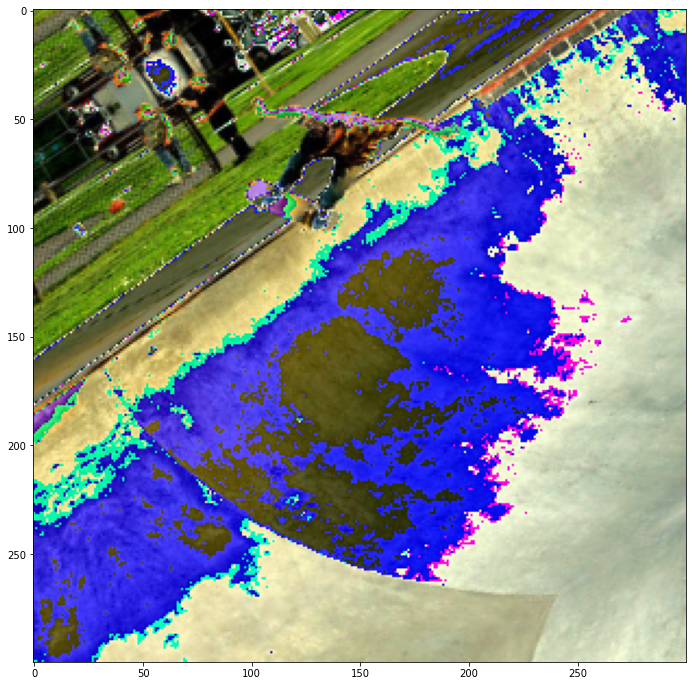

In [41]:
n = random.randint(1,1000)
image,boxes,label = SSD_dataset[n]
to_pil = transforms.ToPILImage()
img = to_pil(image).convert('RGB')
draw = ImageDraw.Draw(img)
fig , ax = plt.subplots(1,1,figsize = (12,12))
for i,box in enumerate(boxes):
    x1,y1,x2,y2 = box[0]-box[2]/2, box[1]-box[3]/2, box[0]+box[2]/2, box[1]+box[3]/2
    draw.rectangle((x1,y1,x2,y2),outline=(0,0,0), width=3)
plt.imshow(img)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from SSD.loss import SSD_Loss
from SSD.utils import convert_to_ratio, object_detection, cal_mAP50

learning_rate = 1e-4
# momentum = 0.9
weight_decay = 0.0005
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = SSD_Loss()

epochs = 30
all_train = len(train_loader)
all_valid = len(valid_loader)

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0
    for images, bboxes, labels in tqdm(train_loader):
        images = images.to(device)
        bboxes = [box.to(device) for box in bboxes]
        labels = [label.to(device) for label in labels]
        optimizer.zero_grad()

        pred_bboxes,pred_labels = model(images)
        
        loss = criterion(pred_bboxes, pred_labels, bboxes, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss/all_train
    print(f"[epoch  {epoch+1}] : train loss : {train_loss}")

    model.eval()
    val_loss = 0
    all_pred_bboxes, all_pred_labels, all_target_bboxes, all_target_labels = [], [], [], []

    with torch.no_grad():
        for images, target_bboxes, target_labels in tqdm(valid_loader):
            images = images.to(device)
            target_bboxes = [box.to(device) for box in target_bboxes]
            target_labels = [label.to(device) for label in target_labels]
            
            pred_bboxes,pred_labels = model(images)
            loss = criterion(pred_bboxes, pred_labels, target_bboxes, target_labels)
            val_loss += loss/all_valid

            target_ratio_bboxes = convert_to_ratio(images[0] ,target_bboxes)
            all_pred_bboxes.append(pred_bboxes)
            all_pred_labels.append(pred_labels)

            all_target_bboxes.append(target_ratio_bboxes)
            all_target_labels.append(target_labels)
        print(f"[epoch  {epoch+1}] : valid loss : {val_loss}")

        if  epoch%5 == 4:
          all_img_boxes, all_img_labels, all_img_scores = object_detection(all_pred_bboxes, all_pred_labels)
          mAP50_dict = cal_mAP50(all_img_boxes, all_img_labels, all_img_scores, all_target_bboxes, all_target_labels)
          mAP50 = 0
          print(f'====================================')
          print(f'val_loss : {val_loss}')
          for category in json_file['categories']:
              c_id = category['id']
              c_name = category['name']
              print(f'{c_name}({c_id}) : {mAP50_dict[c_id]}')
              mAP50 += mAP50_dict[c_id]/num_classes
          print(f'------------------------------------')
          print(f'    ** mAP50 : {mAP50} **')
          print(f'====================================')

